# DOE 本番解析用 (doe-6)

### ライブラリの一括インポート

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import griddata

from funcs.tse import get_ticker_name_list

### Matplotlib のフォント設定（オプション）

In [3]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

## CSV ファイル一覧の取得

In [4]:
name_doe = "doe-6"  # 実験計画名（フォルダ名）
name_code = "7011"  # 銘柄コード
# name_code = "8306"  # 銘柄コード
dict_code = get_ticker_name_list([name_code])

# データ読み込み
path_dir = os.path.join("..", "output", name_doe, name_code)
list_file = sorted(os.listdir(path_dir))

print("\n分析対象のシミュレーション・ファイル")
print(list_file)

n_tick = len(list_file)
print(f"# of tick files : {n_tick}")

# 最後のファイル名から日付文字列を取得して出力するファイル名に付与するための日付文字列を生成
file_last = list_file[-1]
pattern_date = re.compile(r".+_(\d{8})\..+")
if m := pattern_date.match(file_last):
    date_str = m.group(1)  # 保存ファイル目に付与する日付
else:
    date_str = "00000000"
print(f"\n日付文字列 : {date_str}")


分析対象のシミュレーション・ファイル
['ticks_20250819.csv', 'ticks_20250820.csv', 'ticks_20250821.csv', 'ticks_20250822.csv', 'ticks_20250825.csv', 'ticks_20250826.csv', 'ticks_20250827.csv', 'ticks_20250828.csv', 'ticks_20250829.csv', 'ticks_20250901.csv', 'ticks_20250902.csv', 'ticks_20250903.csv', 'ticks_20250904.csv', 'ticks_20250905.csv', 'ticks_20250908.csv', 'ticks_20250909.csv', 'ticks_20250910.csv', 'ticks_20250911.csv', 'ticks_20250912.csv', 'ticks_20250916.csv', 'ticks_20250917.csv', 'ticks_20250918.csv', 'ticks_20250919.csv', 'ticks_20250922.csv', 'ticks_20250924.csv', 'ticks_20250925.csv', 'ticks_20250926.csv', 'ticks_20250929.csv', 'ticks_20250930.csv', 'ticks_20251001.csv', 'ticks_20251002.csv', 'ticks_20251003.csv', 'ticks_20251006.csv', 'ticks_20251007.csv', 'ticks_20251008.csv', 'ticks_20251009.csv', 'ticks_20251010.csv', 'ticks_20251014.csv', 'ticks_20251015.csv', 'ticks_20251016.csv', 'ticks_20251017.csv', 'ticks_20251020.csv', 'ticks_20251021.csv', 'ticks_20251022.csv', 'ticks_2025

## CSV ファイルの読み込み、連結

In [5]:
list_df = list()
for i, file in enumerate(list_file):
    path_csv = os.path.join(path_dir, file)
    df_tick = pd.read_csv(path_csv)
    if i == 0:
        print("\n日毎のシミュレーション結果例（連結前）")
        print(df_tick)
    list_df.append(df_tick)

df = pd.concat(list_df)
df.reset_index(inplace=True, drop=True)
df.to_csv("doe_results.csv", index=False)
print("\n日毎のシミュレーション結果を連結したデータフレーム")
print(df)


日毎のシミュレーション結果例（連結前）
                    file  code  trade  PERIOD_MA_1  PERIOD_MA_2  total
0    ticks_20250819.xlsx  7011     16           30          300   60.0
1    ticks_20250819.xlsx  7011     12           45          300   40.0
2    ticks_20250819.xlsx  7011     14           60          300   72.0
3    ticks_20250819.xlsx  7011     10           75          300   98.0
4    ticks_20250819.xlsx  7011      6           90          300   37.0
..                   ...   ...    ...          ...          ...    ...
116  ticks_20250819.xlsx  7011      6          120          900   35.0
117  ticks_20250819.xlsx  7011      4          135          900   26.0
118  ticks_20250819.xlsx  7011      4          150          900   27.0
119  ticks_20250819.xlsx  7011      4          165          900   27.0
120  ticks_20250819.xlsx  7011      2          180          900  -19.0

[121 rows x 6 columns]

日毎のシミュレーション結果を連結したデータフレーム
                     file  code  trade  PERIOD_MA_1  PERIOD_MA_2  total
0   

## サマリ統計の算出

In [6]:
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2"]
response_cols = ["trade", "total"]

# 因子ごとに応答の平均を集計（サマリデータ）
df_summary = df.groupby(factor_cols)[response_cols].mean().reset_index()
# ソート（実際の実験順序に合わせる）
df_summary = df_summary.sort_values(["PERIOD_MA_2", "PERIOD_MA_1"], ignore_index=True)
print("サマリ統計")
print(df_summary)

# HTML 形式で出力
styled = df_summary.style.format(
    {"trade": "{:.1f}", "total": "{:.2f}"}
).set_table_styles(
    [
        {"selector": "td", "props": "text-align: right;"},
    ]
)
html = styled.to_html()
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_summary.html",
)
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

サマリ統計
     PERIOD_MA_1  PERIOD_MA_2      trade      total
0             30          300  30.073171   4.256098
1             45          300  22.365854   1.268293
2             60          300  21.024390   2.353659
3             75          300  18.804878   4.695122
4             90          300  17.195122   1.951220
..           ...          ...        ...        ...
116          120          900   8.268293  13.060976
117          135          900   8.073171  12.402439
118          150          900   7.439024  10.841463
119          165          900   6.926829   7.243902
120          180          900   6.682927   5.195122

[121 rows x 4 columns]


## 平均収益の集計

In [7]:
# ファイル名から日付を返す関数
def get_date_from_file(file: str) -> pd.Timestamp:
    pattern = re.compile(r".+_(\d{4})(\d{2})(\d{2})\..+")
    if m := pattern.match(file):
        return pd.to_datetime(f"{m.group(1)}-{m.group(2)}-{m.group(3)}")
    else:
        return pd.to_datetime("1970-01-01")

## 平均収益の算出

In [8]:
target = "total"
list_ser = list()

# 行 - 日付、列 - 実験条件 で収益を整理
for i, file in enumerate(list_file):
    date_str_idx = get_date_from_file(file)
    ser = pd.read_csv(os.path.join(path_dir, file))[target]
    # pd.Series の name に日付を設定
    ser.name = date_str_idx
    if i == 0:
        print("日毎のシミュレーション結果 (total のみ）例（連結前の Series）")
        print(ser)
    list_ser.append(ser)
# pd.Series を結合して転置
df_mean = pd.concat(list_ser, axis=1).T
print("\ndf_mean: まだ平均値ではなく、その日の収益（Series を連結）")
print(df_mean)

# データスコープを示す文字列
dt_start = df_mean.index[0]
dt_end = df_mean.index[-1]
title_scope = (
    f"{dict_code[name_code]} ({name_code}) from {dt_start.date()} to {dt_end.date()}"
)
print("データスコープを示す文字列")
print(title_scope)

# 平均収益の算出
n = len(df_mean.index)
while n > 0:
    # 最下行から順に平均値を算出して、行の内容を置換。
    df_mean.iloc[n - 1] = df_mean[:n].mean()
    n -= 1
print("\ndf_mean: 新しい日付から古い日付と逆順に平均収益を算出")
print(df_mean)

# 最終日の平均収益のランキング
ser_ranking = df_mean.iloc[len(df_mean) - 1].sort_values(ascending=False)
print("最新の平均収益（逆ソート後）")
print(ser_ranking)

日毎のシミュレーション結果 (total のみ）例（連結前の Series）
0      60.0
1      40.0
2      72.0
3      98.0
4      37.0
       ... 
116    35.0
117    26.0
118    27.0
119    27.0
120   -19.0
Name: 2025-08-19 00:00:00, Length: 121, dtype: float64

df_mean: まだ平均値ではなく、その日の収益（Series を連結）
             0     1     2     3     4     5     6     7     8     9    ...  \
2025-08-19  60.0  40.0  72.0  98.0  37.0  39.0  29.0  45.0  43.0  49.0  ...   
2025-08-20  17.0 -13.0  -6.0  41.0  53.0   2.0 -13.0  27.0  40.0  -3.0  ...   
2025-08-21 -26.0 -17.0  12.0  16.0  19.0  24.0  35.0  32.0   4.0  -7.0  ...   
2025-08-22 -11.0 -27.0 -24.0 -30.0 -13.0 -11.0   6.0 -12.0 -11.0   0.0  ...   
2025-08-25  10.0  15.0  18.0   7.0  -7.0 -13.0  -6.0  -8.0 -14.0 -14.0  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
2025-12-11  12.0  54.0  39.0  53.0  46.0  69.0  92.0  87.0  32.0   2.0  ...   
2025-12-12  11.0  51.0  47.0  69.0  62.0  61.0  26.0  35.0  49.0  59.0  ...   
2025-12-15  27.0  20.0 -

### 検算

In [9]:
"""
サマリ統計 (df_summary) の平均値と、算出した平均収益 (df_mean) の
最終日の値が一致していることを、
差分をとって平方和が 0 になることで確認
"""

# 差分の平方和 (SSD, Sum of Squared Differences)
ssd = ((df_summary["total"] - df_mean.iloc[n - 1]) ** 2).sum()
print(ssd)

0.0


## ランキング

In [10]:
# トップランキング
n_top = 5
best_conditions = list(ser_ranking.index[:n_top])
df_best = df_summary.iloc[best_conditions]
print("---\n[Best Conditions]")
print(df_best)

# HTML 形式で出力
styled = df_best.style.format({"trade": "{:.1f}", "total": "{:.2f}"}).set_table_styles(
    [
        {"selector": "td", "props": "text-align: right;"},
    ]
)

html = styled.to_html()
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_best.html",
)
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 最新の平均収益が負になっている実験条件
negative_condition = ser_ranking[ser_ranking < 0].index
df_negative = df_summary.iloc[negative_condition]
print("---\n[Bad Conditions]")
print(df_negative)

# HTML 形式で出力
styled = df_best.style.format({"trade": "{:.1f}", "total": "{:.2f}"}).set_table_styles(
    [
        {"selector": "td", "props": "text-align: right;"},
    ]
)

html = styled.to_html()
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_negative.html",
)
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

---
[Best Conditions]
    PERIOD_MA_1  PERIOD_MA_2      trade      total
47           75          540  13.853659  15.756098
90           60          780  14.048780  14.560976
49          105          540  11.682927  14.439024
57           60          600  15.585366  13.804878
64          165          600   8.341463  13.475610
---
[Bad Conditions]
Empty DataFrame
Columns: [PERIOD_MA_1, PERIOD_MA_2, trade, total]
Index: []


## 実験条件毎の収益トレンド

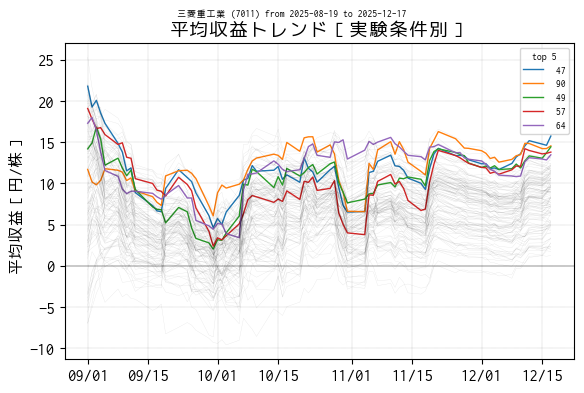

In [11]:
# ---------------------------------------------------------
# 実験条件毎の平均収益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

dt_from = pd.to_datetime("2025-09-01")
df_trend = df_mean[dt_from <= df_mean.index]

for colname in ser_ranking.index:
    if colname in best_conditions:  # トップ 5 だけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    elif colname in negative_condition:  # 最新の平均収益が負になっている条件
        ax.plot(df_trend[colname], linewidth=0.5, linestyle="solid", color="black")
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.1)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("平均収益［円/株］")
ax.set_title("平均収益トレンド［実験条件別］")
# 凡例
lg = ax.legend(fontsize=7)
lg.set_title(f"top {len(best_conditions)}", prop={"size": 7})

output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_trend_mean_profit_{target}.png",
)
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## 生データで等高線図 (Contour Map)

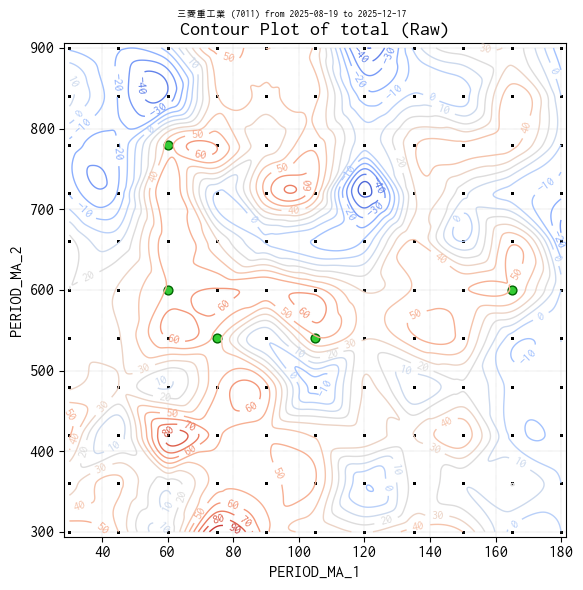

In [12]:
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_x = "PERIOD_MA_1"
col_y = "PERIOD_MA_2"
col_z = "total"
x = df[col_x]
y = df[col_y]
z = df[col_z]

# グリッド作成
pitch = 100
dx = (x.max() - x.min()) / pitch
dy = (y.max() - y.min()) / pitch
xi = np.linspace(x.min() - dx, x.max() + dx, pitch * 5)
yi = np.linspace(y.min() - dy, y.max() + dy, pitch * 5)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

# Contour Map
cont = ax.contour(Xi, Yi, Zi, levels=15, cmap="coolwarm", linewidths=1)
ax.clabel(cont, inline=True, fontsize=9)

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title("Contour Plot of total (Raw)")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.25)

# 最適点
ax.scatter(
    df_best[col_x],
    df_best[col_y],
    marker="o",
    facecolor="limegreen",
    edgecolor="darkgreen",
    s=40,
    zorder=1,
)

# 最新の平均収益が負になる点
ax.scatter(
    df_negative[col_x],
    df_negative[col_y],
    marker="x",
    color="black",
    s=60,
    zorder=1,
)

# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=1, marker=".", zorder=0)

output = os.path.join(
    "..", "output", name_doe, f"{date_str}_{name_code}_raw_contour_{target}.png"
)

plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.925)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

最高収益
                     file  code  trade  PERIOD_MA_1  PERIOD_MA_2  total
6371  ticks_20251105.xlsx  7011     18           60          720  321.0

最低収益
                     file  code  trade  PERIOD_MA_1  PERIOD_MA_2  total
5866  ticks_20251029.xlsx  7011     28           75          600 -189.0



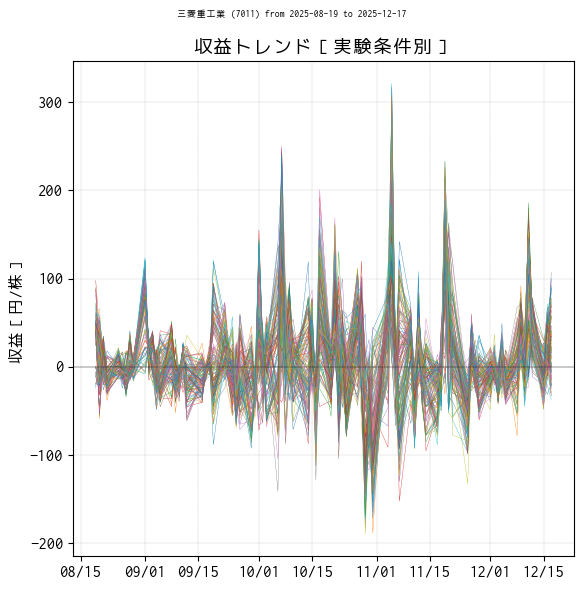

In [13]:
# 実験水準
list_factor_1 = sorted(list(set(df[factor_cols[0]])))
list_factor_2 = sorted(list(set(df[factor_cols[1]])))
profit_max = -np.inf
profit_min = +np.inf
# ---------------------------------------------------------
# 実験条件毎の収益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

for factor_1 in list_factor_1:
    for factor_2 in list_factor_2:
        df_profit = df[
            (df[factor_cols[0]] == factor_1) & (df[factor_cols[1]] == factor_2)
        ]
        df_profit.index = [get_date_from_file(file) for file in df_profit["file"]]

        profit_max_local = df_profit["total"].max()
        if profit_max < profit_max_local:
            profit_max = profit_max_local

        profit_min_local = df_profit["total"].min()
        if profit_min_local < profit_min:
            profit_min = profit_min_local
        n_cond = int(
            df_summary[
                (df_summary[factor_cols[0]] == factor_1)
                & (df_summary[factor_cols[1]] == factor_2)
            ].index[0]
        )
        ax.plot(df_profit["total"], linewidth=0.25, label=f"{n_cond}")

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("収益［円/株］")
ax.set_title("収益トレンド［実験条件別］")
# 凡例
# lg = ax.legend(fontsize=7)
# lg.set_title(f"top {len(best_conditions)}", prop={"size": 7})

print("最高収益")
print(df[df["total"] == profit_max])
print("\n最低収益")
print(df[df["total"] == profit_min])
print()

output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_trend_profit_{target}.png",
)
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
# plt.savefig(output)
plt.show()